In [181]:
#!/usr/bin/env python
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import visvis as vv

import os
import glob
import pyexr
import json
import OpenEXR

import imageio
imageio.plugins.freeimage.download()
try:
    to_unicode = unicode
except NameError:
    to_unicode = str

In [67]:
# projection stuff 
# part 1 : make a voxel and then make a projection

g= np.ones((256,256,32))
g[:,:,1:] = 1
g[:,:,2:] = 2

for i in xrange(32):
    g[:,:,i:]=2**(i-1)

print 'voxel channel 1 has'
print g[255,3,1]

print 'voxel channel 2 has '
print g[244,4,2]

print 'voxel channel 3 has '
print g[244,4,3]

voxel channel 1 has
1.0
voxel channel 2 has 
2.0
voxel channel 3 has 
4.0


In [68]:
# read reference and adjacent images
#read json file to extract extrinsic matrix

ref = cv2.imread('/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0000.png')
adj1 = cv2.imread('/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0001.png')

with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0000.json') as json_data:
    d = json.load(json_data)
    print(d)
    
d0=d
d0[u'c_x']
h0= d0[u'extrinsic']
h0 = np.asarray(h0)
h0.size
h_ref = h0

{u'c_y': 540, u'c_x': 960, u'extrinsic': [[0.2912225672444199, -0.9566583930814945, -1.1050980618446116e-06, 10468.506332562349], [0.04214992399226091, 0.012831574855939424, 0.9990278085726401, 380.3140607381877], [0.9557203733744195, 0.2909469964707039, -0.044059201127544634, 1720.458354459683], [0.0, 0.0, 0.0, 1.0]], u'f_x': 1157.8473936386729, u'f_y': 1157.8410025185074}


In [69]:
print h_ref.shape
print h_ref



(4, 4)
[[ 2.91222567e-01 -9.56658393e-01 -1.10509806e-06  1.04685063e+04]
 [ 4.21499240e-02  1.28315749e-02  9.99027809e-01  3.80314061e+02]
 [ 9.55720373e-01  2.90946996e-01 -4.40592011e-02  1.72045835e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [70]:
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0001.json') as json_data:
    d = json.load(json_data)
    print(d)
    
d0=d
d0[u'c_x']
h0= d0[u'extrinsic']
h0 = np.asarray(h0)
h0.size
h_adj = h0

print h_adj.shape
print h_adj

{u'c_y': 540, u'c_x': 960, u'extrinsic': [[0.2912225672444199, -0.9566583930814945, -1.1050980618446116e-06, 10468.506332562349], [0.04214992399226091, 0.012831574855939424, 0.9990278085726401, 380.3140607381877], [0.9557203733744195, 0.2909469964707039, -0.044059201127544634, 1720.458354459683], [0.0, 0.0, 0.0, 1.0]], u'f_x': 1157.8473936386729, u'f_y': 1157.8410025185074}
(4, 4)
[[ 2.91222567e-01 -9.56658393e-01 -1.10509806e-06  1.04685063e+04]
 [ 4.21499240e-02  1.28315749e-02  9.99027809e-01  3.80314061e+02]
 [ 9.55720373e-01  2.90946996e-01 -4.40592011e-02  1.72045835e+03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [71]:
# pixel to camera frame
d0[u'c_x']


960

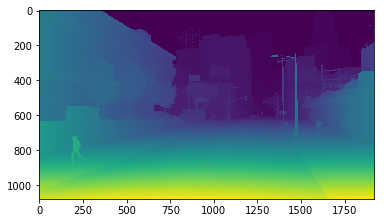

In [184]:
filename = "/graphics/scratch/mallick/MVS_synth/GTAV_1080/0000/depths/0000.exr"
dep0 = OpenEXR.InputFile(filename)
dpth = np.asarray(dep0)
file = pyexr.open(filename)
file.channels               # [R, G, B]
file.width                  # 1280
file.height                 # 720
#file.channel_precision["R"] # pyexr.FLOAT
img = pyexr.read(filename)  
#img = file.get()                         # (720,1280,3) np.float32 array
#img = file.get(precision=pyexr.HALF)          # (720,1280,3) np.float16 array
#red = file.get("R")                  # (720,1280,1) np.float32 array
#red = file.get("R", precision=pyexr.HALF) # (720,1280,1) np.float16 array
def max_disparity_adjust(d, max_disparity_mu = 1.2, max_disparity_sigma = 0.2):
 return d * np.random.normal(max_disparity_mu, max_disparity_sigma)
np.min(img)
#replacing infinity to zero to calculate the second highest value
#img[np.isinf(img)] = 0
#np.max(img)
ref_depth_full=img
valid_mask_full = ref_depth_full != 0.0

ref_depth_full = np.where(valid_mask_full, 1.0 / ref_depth_full, 0.0)
max_disparity = max_disparity_adjust(np.max(ref_depth_full))
ref_depth_full
max_disparity

plt.imshow(ref_depth_full[:,:,0])
img = pyexr.read(filename)  

In [88]:
# we have reference depth map only, but projections can be made if voxels space is provided from inverse space.
# anyways we do a projection from reference from to neighbour
# hint : go to world space first 

#step 1 : read pose matrix of reference 
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0000.json') as json_data:
    d = json.load(json_data)
r_info = d
r_c_x = r_info["c_x"]
r_c_y = r_info["c_y"]
r_f_x = r_info["f_x"]
r_f_y = r_info["f_y"]
r_extrinsic = np.array(r_info["extrinsic"])

#step 2 : continued later
r_extrinsic

array([[ 2.91222567e-01, -9.56658393e-01, -1.10509806e-06,
         1.04685063e+04],
       [ 4.21499240e-02,  1.28315749e-02,  9.99027809e-01,
         3.80314061e+02],
       [ 9.55720373e-01,  2.90946996e-01, -4.40592011e-02,
         1.72045835e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [105]:
#projection from neighbour to reference
r_c_x

960

In [75]:
valid_mask_full = ref_depth_full != 0.0 #returns only true or false

In [76]:
print r_f_x
print r_f_y

1157.84739364
1157.84100252


In [101]:
k=imageio.imread(filename)

In [155]:
h=1/np.max(k)
h

0.0

In [173]:
# so we have values in meters for depth and coordinate system in pixel position and stuff. 

#step2: So we have in ICS. So we need to convert to IPCS 
# check pixels per metres, in my computer screen, it is http://lcdtech.info/en/data/pixel.size.htm = 0.000216
# formula 2.9 from the thesis page 9
scale_y = scale_x = 0.000216

r = 100
c = 25
z_c = 1000000.0

ic = 1/z_c


v = scale_y*(r - r_c_y)
u = scale_x*(c - r_c_x)

print v,u
ic

-0.09504 -0.20196


1e-06

In [174]:
# step3 ; IPCS to CCS , formula 2.8 from the thesis
f = (r_f_x + r_f_y)/2

#x_c = z_c*u/f
#y_c = z_c*v/f

x_c = (u/(f*ic))
y_c = (v/(f*ic))

# so we have x_c, y_c and z_c

#print x_c,y_c,z_c

p_c = np.array([x_c,y_c,z_c, 1.0])
print p_c

[-1.74427613e+02 -8.20835827e+01  1.00000000e+06  1.00000000e+00]


In [175]:
# step 4 : project to world coordinate equation 2.13
np.shape(r_extrinsic)

p_w = r_extrinsic.dot(p_c)

p_w

array([ 1.04951299e+04,  9.99399717e+05, -4.25293288e+04,  1.00000000e+00])

In [176]:
# now, reproject the whole stuff to a neighbor frame

#step 5: read the neighbouring 
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0003.json') as json_data:
    d = json.load(json_data)
n_info = d
n_c_x = n_info["c_x"]
n_c_y = n_info["c_y"]
n_f_x = n_info["f_x"]
n_f_y = n_info["f_y"]
n_extrinsic = np.array(n_info["extrinsic"])

n_extrinsic

array([[ 5.40588128e-01, -8.41283581e-01,  2.28549102e-06,
         1.05450969e+04],
       [-5.12259488e-02, -3.29163926e-02,  9.98149486e-01,
         3.73474260e+02],
       [ 8.39721900e-01,  5.39582382e-01,  6.08814514e-02,
        -1.15093015e+03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [177]:
# world coordinates we have. now we should convert to ICS of the neighbouring frame
from numpy.linalg import inv

#step 6 : find pc
p_c_n = inv(n_extrinsic).dot(p_w)
p_c_n

x_c_n= p_c_n[0]
y_c_n= p_c_n[1]
z_c_n= p_c_n[2]

z_c_n

994648.5234973723

In [178]:
#step 7 : find CCS to IPCS
f = (n_f_x + n_f_y)/2
u_n = (f/z_c_n)*x_c
v_n = (f/z_c_n)*y_c

u_n

-0.20304644508251668

In [179]:
# step 8 : find IPCS to ICS

r_n = np.ceil((v_n/scale_y) + n_c_y)
c_n = np.ceil((u_n/scale_x) + n_c_x)

print r_n,c_n

98.0 20.0


In [180]:
#put it all together

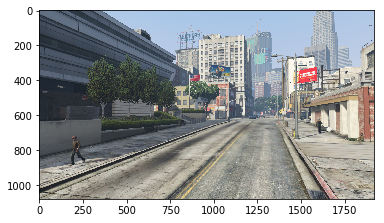

In [240]:
ref_depth_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/depths/0000.exr"
ref_image_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0000.png"

nei_depth_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/depths/0003.exr"
nei_image_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0003.png"


#step 1 : read pose matrix of reference and neighbour
with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0000.json') as json_data:
    d = json.load(json_data)
r_info = d
r_c_x = r_info["c_x"]
r_c_y = r_info["c_y"]
r_f_x = r_info["f_x"]
r_f_y = r_info["f_y"]
r_extrinsic = np.array(r_info["extrinsic"])

with open('/home/mallick/3D_project/MVS_stuckler/MVS_test/poses/0003.json') as json_data:
    d = json.load(json_data)
n_info = d
n_c_x = n_info["c_x"]
n_c_y = n_info["c_y"]
n_f_x = n_info["f_x"]
n_f_y = n_info["f_y"]
n_extrinsic = np.array(n_info["extrinsic"])

#step 2 : continued later
# check pixels per metres, in my computer screen, it is http://lcdtech.info/en/data/pixel.size.htm = 0.000216
# formula 2.9 from the thesis page 9
scale_y = scale_x = 0.000216


## read the images ##
ref_img = mpimg.imread(ref_image_file)
ref_depth = pyexr.read(ref_depth_file)  
nei_img = mpimg.imread(nei_image_file)
nei_depth = pyexr.read(nei_depth_file) 

shape_re = np.shape(ref_depth) # 1080,1920,1

#show the image
ref_img[1079,1919,0]
imgplot = plt.imshow(ref_img)


v = np.zeros(shape_re[0])
u = np.zeros(shape_re[1])
inv_depth=np.zeros((1080,1920))
p_c = np.zeros((1080,1920))
p_w = np.zeros((1080,1920))
y_proj = np.zeros(shape_re[0])
x_proj = np.zeros(shape_re[1])
projected_image = np.zeros((1080,1920,3))

for x_r in xrange(shape_re[1]):
    for y_r in xrange(shape_re[0]):
        #step a: convert to IPCS from ICS
        v[y_r] = scale_y*(y_r - r_c_y)
        u[x_r] = scale_x*(x_r - r_c_x)
        #step b: convert to CCS from IPCS
        if ref_depth[y_r,x_r]>100000:
            ref_depth[y_r,x_r]=100000
            
        ic=inv_depth[y_r,x_r] = 1/ref_depth[y_r,x_r,0]
        x_c = (u[x_r]/(f*ic))
        y_c = (v[y_r]/(f*ic))
        z_c = ref_depth[y_r,x_r,0]
        #step c: CCS to world
        # step 4 : project to world coordinate equation 2.13
        p_c = np.array([x_c,y_c,z_c, 1.0])
        p_w = r_extrinsic.dot(p_c)
        #step 5 : find pc from world
        p_c_n = inv(n_extrinsic).dot(p_w)
        p_c_n
        #world to ccs
        x_c_n= p_c_n[0]
        y_c_n= p_c_n[1]
        z_c_n= p_c_n[2]
        
        #ccs to ICS
        u_n = (f/z_c_n)*x_c
        v_n = (f/z_c_n)*y_c
        
        #ICS to IPCS
        y_proj[y_r] = np.ceil((v_n/scale_y) + n_c_y)
        x_proj[x_r] = np.ceil((u_n/scale_x) + n_c_x)
        
        
        if ((x_proj[x_r].astype(int) > 1919) or (y_proj[y_r].astype(int) > 1079)):
            projected_image[y_r,x_r,:] = 0
        else:
            projected_image[y_r,x_r,:]=ref_img[y_proj[y_r].astype(int),x_proj[x_r].astype(int),:]
        
        
       

      


In [241]:
x_c

0.01407758996520885

In [242]:
np.max(ref_depth)

100000.0

In [243]:
p_c

array([1.4077590e-02, 7.9122221e-03, 7.8687500e+01, 1.0000000e+00])

In [244]:
np.shape(y_proj)
np.max(x_proj)

1251.0

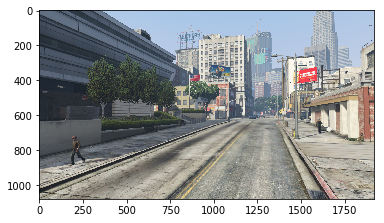

In [245]:
#show the image now in projected mode
nei_image_file = "/home/mallick/3D_project/MVS_stuckler/MVS_test/images/0003.png"
imgplot = plt.imshow(ref_img)

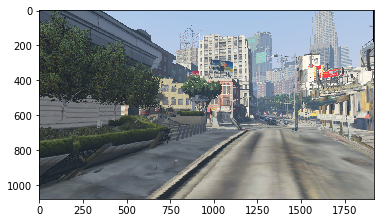

In [246]:
proj_imgplot = plt.imshow(projected_image)